# Evolutionary Computation Assignment 7

##### Solutions checked by solution checker

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [1]:
from utils import TspInstance, random_solution, local_search
import numpy as np
import time

In [2]:
def greedy_repair_cycle(tsp: TspInstance, partial_solution):
    
    solution = partial_solution.copy()

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = selected_path_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for insertion_index in range(len(solution)):
                start = solution[insertion_index]
                end = solution[(insertion_index + 1) % len(solution)]
                cost = (
                    tsp.node_costs[node_index]
                    + tsp.distance_matrix[start][node_index]
                    + tsp.distance_matrix[node_index][end]
                    - tsp.distance_matrix[start][end]
                )

                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    selected_path_index = insertion_index
                    min_cost = cost

        solution = list(solution)
        solution.insert(selected_path_index + 1, selected_node_index)

    return np.array(solution)

# Problem description - Large Neighbourhood Search

- Destroy operator should remove a relatively large fraction of nodes/edges from the current solution,
e.g. 20-30%. The removed edges could be selected at random, as a single subpath, or several
subpaths. You can try to propose some heuristic rules to remove “bad” nodes/edges, e.g. long edges
or costly nodes. Such heuristics should be, however, randomized not completely deterministic. For
example the probability of removal should depend on the length/cost.
- As repair operator use the best greedy heuristic (including greedy-regret) from previous assignments.
The destroy-repair operators should be clearly described.
- As the starting solution use random solution.
- Implement two versions of LNS – using or not local search after destroy-repair operators. Use the
best version of steepest local search. Always apply local search to the initial solution.



```
Generate an initial solution x
x := Local search (x) (optional)
Repeat
y := Destroy (x)
y := Repair (y)
y := Local search (y) (optional)
If f(y) > f(x) then
x := y
Until stopping conditions are met
```

In [3]:
def single_inter_move_v1(tsp, solution, to_unselect, to_select):
    solution = solution.copy()
    insert_index = np.where(solution == to_unselect)[0][0]

    prev = solution[insert_index - 1]
    next = solution[(insert_index + 1) % len(solution)]

    cost_change = (
        tsp.node_costs[to_select]
        + tsp.distance_matrix[prev, to_select]
        + tsp.distance_matrix[to_select, next]
        - tsp.node_costs[to_unselect]
        - tsp.distance_matrix[prev, to_unselect]
        - tsp.distance_matrix[to_unselect, next]
    )

    return cost_change, to_unselect, to_select, "inter"

def single_inter_move(tsp, solution, given_node, to_select, inter_type):
    
    unselect_index = (np.where(solution == given_node)[0][0]) % len(solution)
    to_unselect = solution[unselect_index]
    cost_change, to_unselect, to_select, move_type = single_inter_move_v1(tsp, solution, to_unselect, to_select)
    
    removed_edges = [(solution[(unselect_index - 1) % len(solution)], to_unselect), (to_unselect, solution[(unselect_index + 1) % len(solution)])]
    added_edges =   [(solution[(unselect_index - 1) % len(solution)], to_select),   (to_select, solution[(unselect_index + 1) % len(solution)])]
    
    removed_edges = tuple(sorted([tuple(map(int, edge)) for edge in removed_edges]))
    added_edges = tuple(sorted([tuple(map(int, edge)) for edge in added_edges]))

    removed_edges = tuple(sorted(removed_edges))
    added_edges = tuple(sorted(added_edges))
    
    cost_change = int(cost_change)
    given_node = int(given_node)
    to_select = int(to_select)
    
    return cost_change, given_node, to_select, move_type, inter_type, removed_edges, added_edges

def apply_inter_move(solution, given_node, to_select, inter_type):
    solution = solution.copy()
    if inter_type == "next":
        unselect_index = (np.where(solution == given_node)[0][0] + 1) % len(solution)
        solution[unselect_index] = to_select
    else:
        unselect_index = (np.where(solution == given_node)[0][0] - 1) % len(solution)
        solution[unselect_index] = to_select
    return solution

In [4]:
def single_intra_move(tsp, solution, a, b, intra_type):
    solution = solution.copy()
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]

    if abs(index_a - index_b) == 1:
        return 0, a, b, "intra"
    
    if intra_type == "next":
        a_next = solution[(index_a + 1) % len(solution)]
        b_next = solution[(index_b + 1) % len(solution)]

        cost_change = (
            tsp.distance_matrix[a, b]
            + tsp.distance_matrix[a_next, b_next]
            - tsp.distance_matrix[a, a_next]
            - tsp.distance_matrix[b, b_next]
        )
        removed_edges = [(solution[index_a], solution[(index_a + 1) % len(solution)]), (solution[index_b], solution[(index_b + 1) % len(solution)])]
        added_edges =   [(solution[index_a], solution[index_b]), (solution[(index_a + 1) % len(solution)], solution[(index_b + 1) % len(solution)])]
    elif intra_type == "prev":
        
        a_prev = solution[(index_a - 1) % len(solution)]
        b_prev = solution[(index_b - 1) % len(solution)]

        cost_change = (
            tsp.distance_matrix[a, b]
            + tsp.distance_matrix[a_prev, b_prev]
            - tsp.distance_matrix[a_prev, a]
            - tsp.distance_matrix[b_prev, b]
        )
        removed_edges = [(solution[(index_a - 1) % len(solution)], solution[index_a]), (solution[(index_b - 1) % len(solution)], solution[index_b])]
        added_edges  =  [(solution[index_a], solution[index_b]), (a_prev,b_prev)]
        
    removed_edges = tuple(([tuple(map(int, edge)) for edge in removed_edges]))
    added_edges   = tuple(([tuple(map(int, edge)) for edge in added_edges]))
    
    removed_edges = tuple(removed_edges)
    added_edges   = tuple(added_edges)
    
    cost_change = int(cost_change)
    a = int(a)
    b = int(b)

    return cost_change, a, b, "intra", intra_type, removed_edges, added_edges

def apply_intra_move(solution, a, b, intra_type):
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]
    solution = solution.copy()
    if intra_type == "next":
        if index_a < index_b:
            subsequence = solution[(index_a + 1) : index_b + 1][::-1]
            solution[(index_a + 1) : index_b + 1] = subsequence
        else:
            subsequence = solution[(index_b + 1) : index_a + 1][::-1]
            solution[(index_b + 1) : index_a + 1] = subsequence
            
    elif intra_type == "prev":
        if index_a < index_b:
            subsequence = solution[index_a : index_b][::-1]
            solution[index_a : index_b] = subsequence
        else:
            subsequence = solution[index_b : index_a][::-1]
            solution[index_b : index_a] = subsequence
    return solution

In [5]:
def get_k_node_moves(tsp, solution, candidate_list, a):
    closest_vertices = np.argsort(tsp.distance_matrix[a] + tsp.node_costs)
    closest_vertices = closest_vertices[closest_vertices != a][:10]

    for b in closest_vertices:
        if b in solution:
            move_1 = single_intra_move(tsp, solution, a, b, "next")
            move_2 = single_intra_move(tsp, solution, a, b, "prev")
        else:
            move_1 = single_inter_move(tsp, solution, a, b, "next")
            move_2 = [1, a, b, "inter", "next", [], []]
            
        move_1 = tuple(move_1)
        move_2 = tuple(move_2)

        if move_1[0] < 0:
            candidate_list.append(move_1)
        if move_2[0] < 0:
            candidate_list.append(move_2)
    return candidate_list

def add_new_moves(tsp, solution, candidate_list, move):
    if move[3] == "inter":
        new_node = move[2]
        candidate_list = get_k_node_moves(tsp, solution, candidate_list, new_node)
    elif move[3] == "intra":
        new_edges = move[6]
        for edge in new_edges:
            for x in edge:
                candidate_list = get_k_node_moves(tsp, solution, candidate_list, x)
    return candidate_list

def check_if_applicable(move, all_edges, solution):
    removed_edges = move[5]
    # if any edges to remove is not in all edges, then move is not applicable
    if not all(edge in all_edges for edge in removed_edges):
        return False
    
    if move[3] == "inter":
        to_select = move[2]
        if to_select in solution:
            return False
    
    return True

In [6]:
def is_valid_solution(tsp, solution):
    if len(solution) != len(set(solution)):
        return False
    # all number are in range 0 to 200
    if not all(0 <= x < 200 for x in solution):
        return False
    return True

def delta_method(tsp: TspInstance, start_node: int, solution: list):
    
    if start_node == 1922:
        solution = solution.copy() 
    else:
        solution = random_solution(tsp, start_node)
        
    if not is_valid_solution(tsp, solution):
        print("Invalid solution")
        return None
    
    candidate_list = []
    
    start_time = time.time()

    for a in solution:
        candidate_list = get_k_node_moves(tsp, solution, candidate_list, a)
                
    while True:
        all_edges = [(solution[i], solution[(i + 1) % len(solution)]) for i in range(len(solution))]
        all_edges = [tuple(map(int, edge)) for edge in all_edges]
        not_applicable = []
        while candidate_list:
            best_move = min(candidate_list, key=lambda x: x[0])
            if check_if_applicable(best_move, all_edges, solution):
                break
            not_applicable.append(best_move)
            candidate_list.remove(best_move)
        
        if not candidate_list:
            break
        
        if best_move[3] == "inter":
            solution = apply_inter_move(solution, best_move[1], best_move[2], best_move[4])
        else:
            solution = apply_intra_move(solution, best_move[1], best_move[2], best_move[4])
        
        candidate_list.extend(not_applicable)
        candidate_list = [x for x in candidate_list if not any(edge in x[5] for edge in best_move[5])]
        
        candidate_list = add_new_moves(tsp, solution, candidate_list, best_move)
        candidate_list = list(set(candidate_list))
        
        if time.time() - start_time > 30:
            break
    
    return solution

# Our Large Neighbourhood Method

## Pseudocode

1. Generate solution by delta method
2. While running time is less than MSLS:
    1. Apply destroy operator
        1. Each node have its cost, but we as node cost, would treat its 'inner' cost + cost of edges adjacent to them
        2. Such costs calculated for each node, would be divided by its sum, creating probability distribution. (the higher the cost the greater the chance to be removed)
        3. Then we remove 20% of nodes by drawing them using calculated probability distribution.
    2. Repair solution, by applying greedy_cycle method
    3. (Depending on the type) apply local search (in our case delta method) to the given solution
    4. Calculate cost of the new solution, check if it's lower than last solution
        - if it is, then change solution that will go to next iteration
        - otherwise, continue without changes

In [2]:
def msls(tsp: TspInstance, start_node: int):
    start = time.time()
    best_solution = None
    while True:
        test_solution = local_search(tsp, 0, random_solution, "edge", True)
        if best_solution is None or tsp.get_cost(best_solution) > tsp.get_cost(
            test_solution
        ):
            best_solution = test_solution

        if time.time() - start > 60:
            return best_solution

In [ ]:
columns = []
experiments = []
methods = [msls]

for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
    for method in methods:
        column = f"{instance.file_path[3]}"
        columns.append(column)
        start = time.time()
        experiment = instance.run_experiments(method)
        print(f"Method: {method.__name__}, Time: {time.time() - start}")
        experiments.append(experiment)

        instance.plot(experiment[-1], column)

In [9]:
def silly_destroy(solution, destroy_size):
    solution = solution.copy()
    destroy_indices = np.random.choice(len(solution), destroy_size, replace=False)
    destroy_indices = np.sort(destroy_indices)[::-1]
    for index in destroy_indices:
        solution = np.delete(solution, index)
    return solution

def destroy_operator(tsp, solution):
    solution = solution.copy()
    destroy_size = int(0.2 * len(solution))
    node_costs = np.zeros(len(solution))

    for i, node in enumerate(solution):
        node_costs[i] = tsp.node_costs[node] + \
            np.sum(tsp.distance_matrix[solution[i], solution[(i + 1) % len(solution)]]) + \
            np.sum(tsp.distance_matrix[solution[i], solution[(i - 1) % len(solution)]])

    node_costs = node_costs / np.sum(node_costs)
    destroy_indices = np.random.choice(len(solution), destroy_size, p=node_costs, replace=False)
    destroy_indices = np.sort(destroy_indices)[::-1]
    for index in destroy_indices:
        solution = np.delete(solution, index)
        
    return solution


def large_neighbour_method_with(tsp: TspInstance, start_node: int):
    
    solution = delta_method(tsp, start_node, None)
    
    best_cost = tsp.get_cost(solution)
    start_node = 1922
    
    start = time.time()
    MSLS_TIME = 30 # 12356.159002542496 (real time)
    counter = 0

    while time.time() - start < MSLS_TIME:
        counter += 1

        destroyed_solution = destroy_operator(tsp, solution)

        new_solution = greedy_repair_cycle(tsp, destroyed_solution)
        
        new_solution = delta_method(tsp, start_node, new_solution)
            
        new_cost = tsp.get_cost(new_solution)
        
        if new_cost < best_cost:
            solution = new_solution
            best_cost = new_cost
        
    return counter, solution


def large_neighbour_method_without(tsp: TspInstance, start_node: int):
    
    solution = delta_method(tsp, start_node, None)
    
    best_cost = tsp.get_cost(solution)
    
    start = time.time()
    MSLS_TIME = 30  # 12356.159002542496 (real time)
    counter = 0

    while time.time() - start < MSLS_TIME:
        counter += 1

        destroyed_solution = destroy_operator(tsp, solution)

        new_solution = greedy_repair_cycle(tsp, destroyed_solution)
    
        new_cost = tsp.get_cost(new_solution)
        
        if new_cost < best_cost:
            solution = new_solution
            best_cost = new_cost
        
    return counter, solution

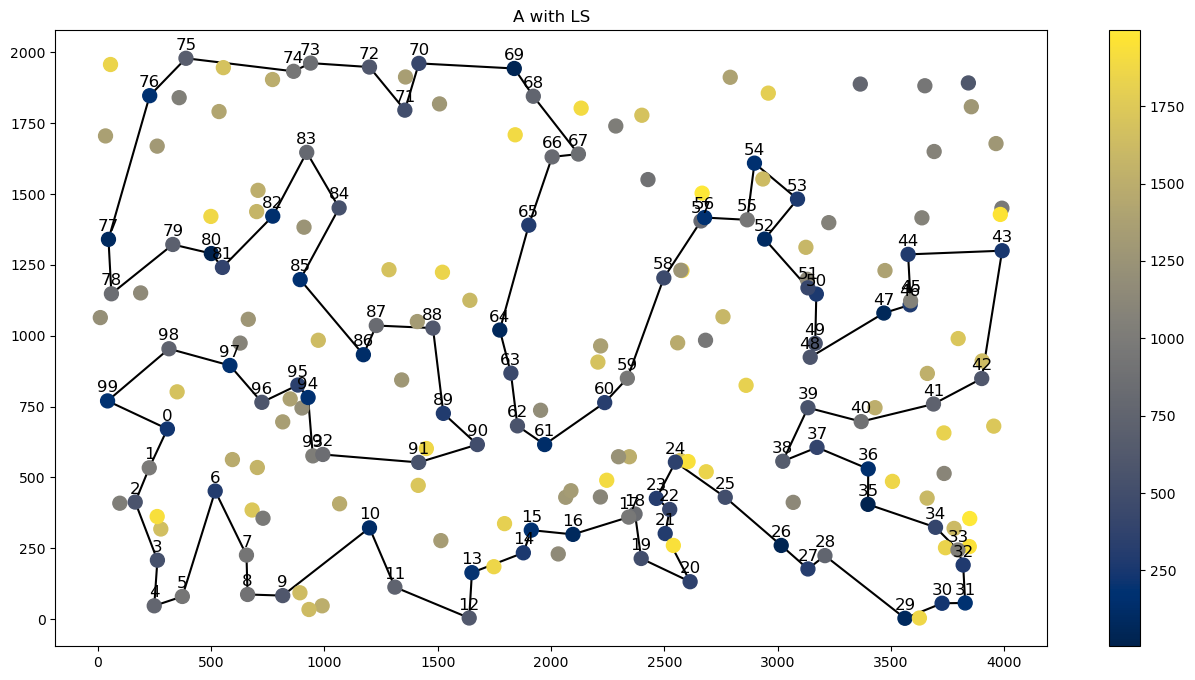

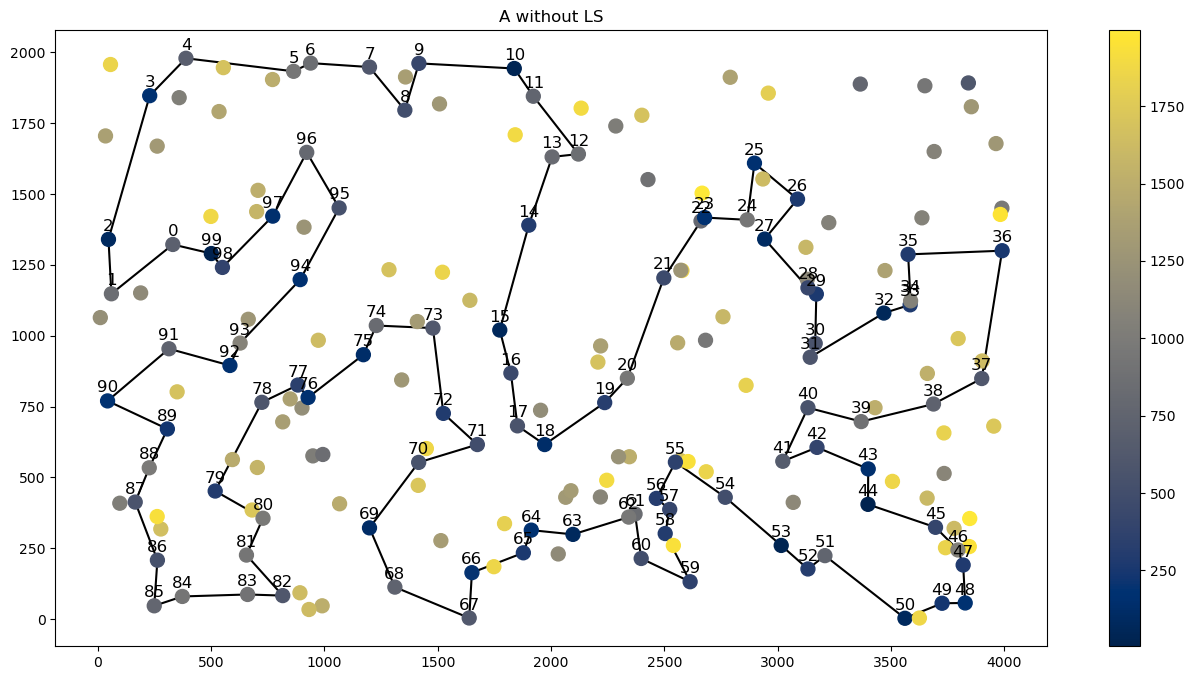

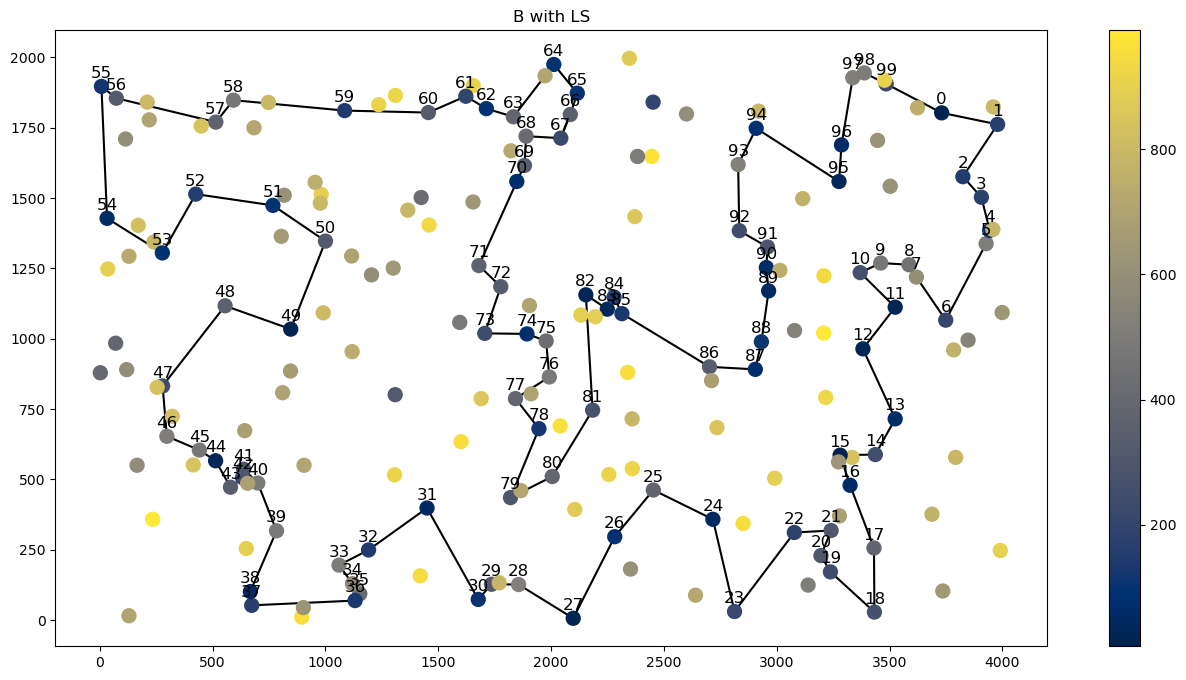

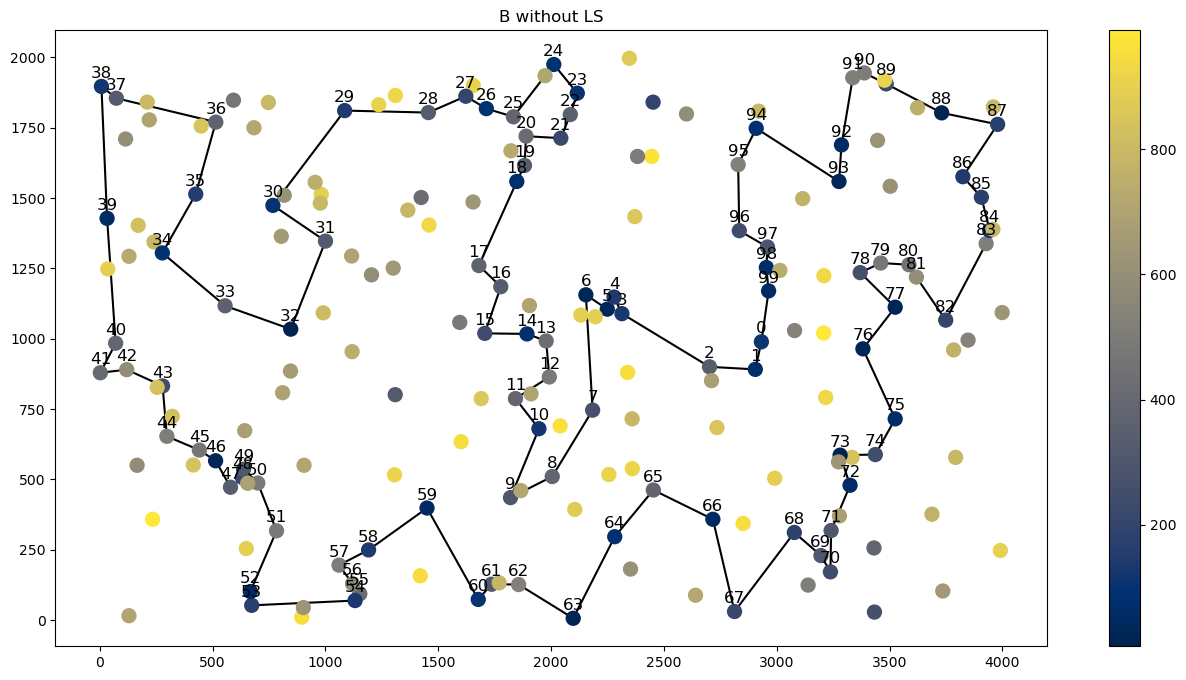

In [11]:
columns = []
experiments = []
lns_types = ["with LS", "without LS"] # after destroy-repair operators
lns_methods = [large_neighbour_method_with, large_neighbour_method_without]

for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
    for lns_type, method in zip(lns_types, lns_methods):
        column = f"{instance.file_path[3]} {lns_type}"
        columns.append(column)

        experiment = instance.run_experiments(method)
        experiments.append(experiment)

        instance.plot(experiment[-4], column)

In [23]:
# rmove from experiments without 7th column, but save to new variable
new_experiments = []
for experiment in experiments:
    new_experiment = experiment[:3] + experiment[7:]
    new_experiments.append(new_experiment)

In [25]:
# transform new experiments to pandas dataframe and save to csv
import pandas as pd
df = pd.DataFrame(
    np.array(tuple(map(lambda x: x, new_experiments))).T,
    columns=columns,
    index=(
        "min_cost",
        "max_cost",
        "average_cost",
        # "min_time",
        # "max_time",
        # "average_time",
        "min_moves",
        "max_moves",
        "average_moves",
    ),
)
df.to_csv("experiments_7.csv", index=False)

In [ ]:
import pandas as pd
pd.DataFrame(
    np.array(tuple(map(lambda x: x, new_experiments))).T,
    columns=columns,
    index=(
        "min_cost",
        "max_cost",
        "average_cost",
        # "min_time",
        # "max_time",
        # "average_time",
        "min_moves",
        "max_moves",
        "average_moves",
    ),
)

# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# ,
# ,
# Results

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A with LS</th>
      <th>A without LS</th>
      <th>B with LS</th>
      <th>B without LS</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>69159.00</td>
      <td>69144.000</td>
      <td>43459.000</td>
      <td>43516.000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>80774.00</td>
      <td>71956.000</td>
      <td>59403.000</td>
      <td>46418.000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>69830.77</td>
      <td>70080.565</td>
      <td>45479.890</td>
      <td>44497.715</td>
    </tr>
    <tr>
      <th>min_moves</th>
      <td>2.00</td>
      <td>292.000</td>
      <td>1.000</td>
      <td>257.000</td>
    </tr>
    <tr>
      <th>max_moves</th>
      <td>285.00</td>
      <td>327.000</td>
      <td>286.000</td>
      <td>313.000</td>
    </tr>
    <tr>
      <th>average_moves</th>
      <td>269.64</td>
      <td>299.965</td>
      <td>201.215</td>
      <td>302.420</td>
    </tr>
  </tbody>
</table>
</div>

<table border="1">
  <thead>
    <tr>
      <th>TSP Instance</th>
      <th>Method</th>
      <th>Min</th>
      <th>Mean</th>
      <th>Max</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="6">A</td>
      <td>Greedy Cycle</td>
      <td>71488.000</td>
      <td>73018.265</td>
      <td>75528.000</td>
    </tr>
    <tr>
      <td>LS Steepest Edges</td>
      <td>70439.000</td>
      <td>71628.765</td>
      <td>73287.000</td>
    </tr>
    <tr>
      <td>MSLS</td>
      <td>71587.000</td>
      <td>72481.400</td>
      <td>73618.000</td>
    </tr>
    <tr>
      <td>ILS</td>
      <td>70881.000</td>
      <td>72064.950</td>
      <td>73487.000</td>
    </tr>
    <tr>
      <td>LNS with LS</td>
      <td>69159.00</td>
      <td>80774.00</td>
      <td>69830.77</td>
    </tr>
    <tr>
      <td>LNS without LS</td>
      <td>69144.000</td>
      <td>71956.000</td>
      <td>70080.565</td>
    </tr>
    <tr>
      <td rowspan="6">B</td>
      <td>Greedy Cycle</td>
      <td>49177.000</td>
      <td>51516.000</td>
      <td>57276.000</td>
    </tr>
    <tr>
      <td>LS Steepest Edges</td>
      <td>48305.000</td>
      <td>50736.525</td>
      <td>56800.000</td>
    </tr>
    <tr>
      <td>MSLS</td>
      <td>45664.000</td>
      <td>46822.450</td>
      <td>47707.000</td>
    </tr>
    <tr>
      <td>ILS</td>
      <td>45119.000</td>
      <td>46239.100</td>
      <td>47922.000</td>
    </tr>
    <tr>
      <td>LNS with LS</td>
      <td>43459.000</td>
      <td>59403.000</td>
      <td>45479.890</td>
    </tr>
    <tr>
      <td>LNS without LS</td>
      <td>43516.000</td>
      <td>46418.000</td>
      <td>44497.715</td>
    </tr>
  </tbody>
</table>


# Conclusions
- Both LNS (Large Neighbourhood Methods) generate better solutions than all prieviously used methods and are better also in average.
- LNS with LS method (after destroy-repair operators) works slightly better than without, as expected.
- Best Method for instance A is `LNS with LS` achieves the lowest minimum cost (69 159)
- Best Method for instance B is `LNS with LS` achieves the lowest minimum cost (43 459)

[Source code: https://github.com/krzychuszala/EC-TSP](https://github.com/krzychuszala/EC-TSP)